In [1]:
import sys; sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from utils.ImagePlot import ImagePlot
plotter = ImagePlot()

np.random.seed(42)

In [2]:
data = pd.read_csv("./data/data.csv")

print(f"Data shape: {data.shape}")
display(data.head())

Data shape: (42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
data = data.to_numpy()
X_full = data[:, 1:].T
Y_full = data[:, 0]

print(X_full.shape, Y_full.shape)

(784, 42000) (42000,)


## Dataset preparation

In [4]:
def extractDigits(X, Y, to_selected_digits):
    to_select_idxs = np.array([False]*Y.shape[0])
    for digit in to_selected_digits:
        to_select_idxs |= (Y == digit)
    return X[:, to_select_idxs], Y[to_select_idxs]


def train_test_split(X, Y, train_size, random_seed=42):
    rng = np.random.default_rng(random_seed)

    idxs = np.arange(0, X.shape[1])
    rng.shuffle(idxs)
    X_train = X[:, idxs[:train_size]]
    Y_train = Y[idxs[:train_size]]
    X_test = X[:, idxs[train_size:]]
    Y_test = Y[idxs[train_size:]]

    return X_train, Y_train, X_test, Y_test

In [5]:
X, Y = extractDigits(X_full, Y_full, [0, 6, 9])
X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]))

print(f"Train set: {X_train.shape}, {Y_train.shape}")
print(f" Test set: {X_test.shape}, {Y_test.shape}")

Train set: (784, 9342), (9342,)
 Test set: (784, 3115), (3115,)


## PCA

In [6]:
def centroid(data):
    return np.expand_dims( np.mean(data, axis=1), 1 )

class PCA:
    def __init__(self):
        self.data_centroid = None
        self.proj_matrix = None

    def fit(self, data, k):
        self.data_centroid = centroid(data)
        centered_data = data - self.data_centroid

        U, _, _ = np.linalg.svd(centered_data, full_matrices=False)
        self.proj_matrix = U[:, :k].T

    def transform(self, data):
        # If a single data point is provided
        if data.ndim == 1:
            data = np.expand_dims(data, axis=1)
            
        data_centered = data - self.data_centroid
        # data_centered = data - centroid(data)
        return self.proj_matrix @ data_centered
    
    def fit_transform(self, data, k):
        self.fit(data, k)
        return self.transform(data)


def plotData(Z_k, Y, title=""):
    for digit in np.unique(Y):
        plt.scatter(Z_k[0, Y==digit], Z_k[1, Y==digit], label=digit, marker=".")
    
    for digit in np.unique(Y):
        cluster_centroid = centroid(Z_k[:, Y==digit])
        plt.scatter(cluster_centroid[0, :], cluster_centroid[1, :], c="darkred", marker="X")

    plt.title(title)
    plt.legend()
    plt.show()

(2, 9342)


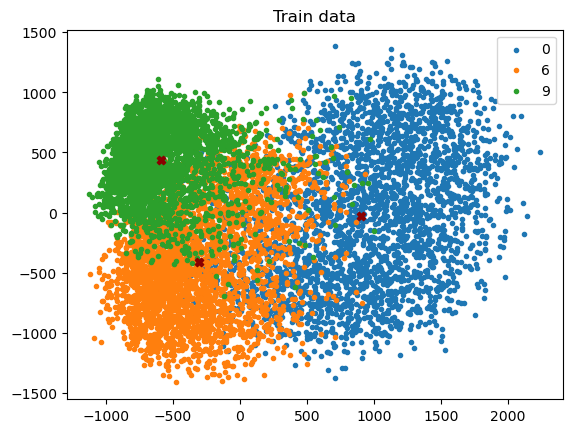

In [7]:
pca = PCA()
Z_k = pca.fit_transform(X_train, 2)

print(Z_k.shape)
plotData(Z_k, Y_train, "Train data")

In [8]:
for digit in np.unique(Y_train):
    Z_cluster = Z_k[:, Y_train == digit]
    cluster_centroid = centroid(Z_cluster)

    dists = []
    for i in range(Z_cluster.shape[1]):
        dists.append( np.linalg.norm(cluster_centroid - Z_cluster[:, i]) )
    print(f"{digit} | train avg. distance to centroid {np.mean(dists)}")

0 | train avg. distance to centroid 1673.5328469435062
6 | train avg. distance to centroid 760.497403121916
9 | train avg. distance to centroid 1549.270693319133


0 | test avg. distance to centroid 1637.2483800204207
6 | test avg. distance to centroid 769.2036870446094
9 | test avg. distance to centroid 1541.170417925061


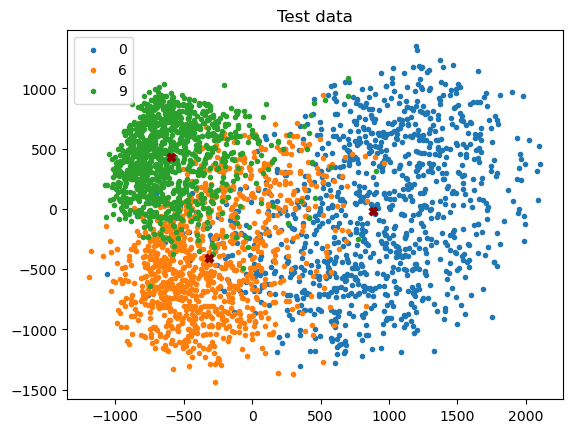

In [9]:
Z_k_test = pca.transform(X_test)

for digit in np.unique(Y_test):
    Z_cluster = Z_k_test[:, Y_test == digit]
    cluster_centroid = centroid(Z_cluster)

    dists = []
    for i in range(Z_cluster.shape[1]):
        dists.append( np.linalg.norm(cluster_centroid - Z_cluster[:, i]) )
    print(f"{digit} | test avg. distance to centroid {np.mean(dists)}")

plotData(Z_k_test, Y_test, "Test data")

## PCA classifier

In [10]:
class MNISTClassifier:
    def __init__(self):
        self.pca = None
        self.Z_k_train = None
        self.possible_digits = None
        self.digits_centroid = None

    def fit(self, X_train, Y_train, k=2):
        self.pca = PCA()
        self.Z_k_train = self.pca.fit_transform(X_train, k)
        self.possible_digits = np.unique(Y_train)
        self.digits_centroid = { digit: centroid(self.Z_k_train[:, Y_train == digit]) for digit in self.possible_digits }

    def predict(self, new_digit):
        Z_k_digit = self.pca.transform(new_digit)
        best_distance = +np.inf
        best_digit = None

        for digit in self.possible_digits:
            distance = np.linalg.norm(self.digits_centroid[digit] - Z_k_digit)
            if distance < best_distance:
                best_distance = distance
                best_digit = digit

        return best_digit
    

def evaluate(model, X_test, Y_test):
    correct = 0
    total_digits = X_test.shape[1]

    for i in range(total_digits):
        prediction = model.predict(X_test[:, i])
        if prediction == Y_test[i]:
            correct += 1
    
    return correct / total_digits, correct, total_digits

In [11]:
classifier = MNISTClassifier()
classifier.fit(X_train, Y_train)

In [12]:
accuracy, correct, total_digits = evaluate(classifier, X_test, Y_test)
print(f"Accuracy: {accuracy:.5f} ({correct}/{total_digits} correct)")

Accuracy: 0.84751 (2640/3115 correct)


## Evaluation

In [13]:
def evaluateOnDigits(digits, X_full, Y_full, k=2):
    X, Y = extractDigits(X_full, Y_full, digits)
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]), random_seed=42)

    classifier = MNISTClassifier()
    classifier.fit(X_train, Y_train, k=k)
    accuracy, _, _ = evaluate(classifier, X_test, Y_test)

    return accuracy


# Prepare the triplets of digits
to_eval_digits = set()

for i in range(0, 10):
    for j in range(i+1, 10):
        for k in range(j+1, 10):
            to_eval_digits.add(tuple(sorted([i, j, k])))

### Varying digits (k=2)

In [14]:
accuracies_df = pd.DataFrame(columns=["digits", "accuracy"])

for digits in tqdm(to_eval_digits):
    accuracy = evaluateOnDigits(digits, X_full, Y_full, k=2)
    accuracies_df.loc[len(accuracies_df)] = [digits, accuracy]

# pd.set_option("display.max_rows", None)
accuracies_df = accuracies_df.sort_values("accuracy", ascending=False)

display(accuracies_df.head())
display(accuracies_df.tail())

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [04:10<00:00,  2.09s/it]


,digits,accuracy
114,"(0, 1, 4)",0.960273
85,"(0, 1, 7)",0.952799
71,"(3, 6, 7)",0.951598
25,"(1, 3, 4)",0.951480
66,"(1, 6, 9)",0.949585


,digits,accuracy
29,"(0, 2, 8)",0.635306
83,"(5, 8, 9)",0.633466
98,"(4, 5, 9)",0.608162
69,"(4, 7, 9)",0.605180
44,"(3, 5, 8)",0.584671


### Varying k

  0%|          | 0/15 [00:00<?, ?it/s]

100%|██████████| 15/15 [00:30<00:00,  2.06s/it]


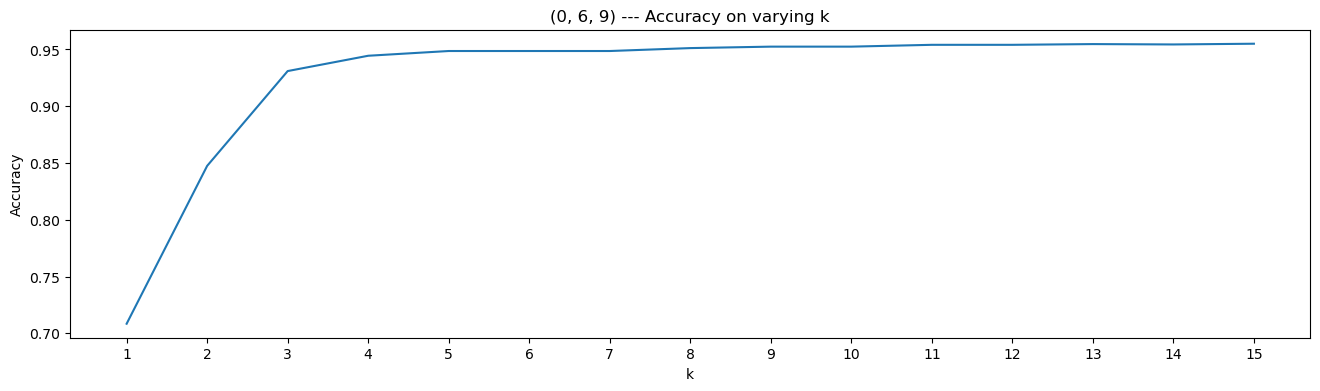

100%|██████████| 15/15 [00:32<00:00,  2.18s/it]


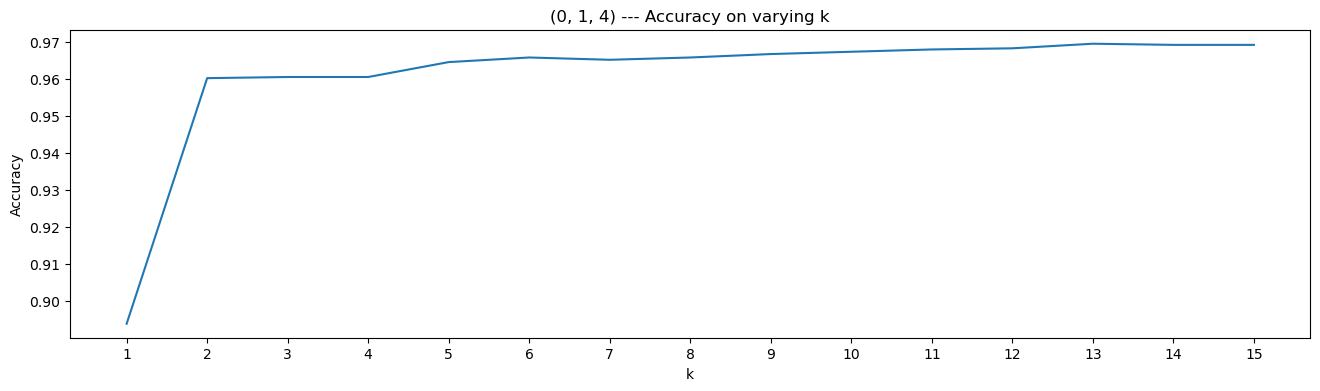

100%|██████████| 15/15 [00:29<00:00,  2.00s/it]


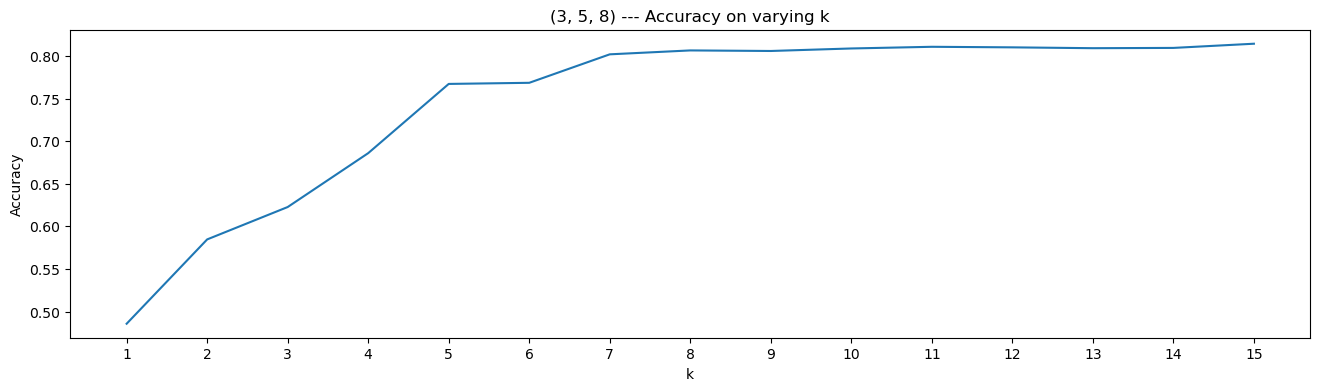

In [15]:
for digits in [ (0, 6, 9), accuracies_df.iloc[0]["digits"], accuracies_df.iloc[-1]["digits"] ]:
    X, Y = extractDigits(X_full, Y_full, digits)
    X_train, Y_train, X_test, Y_test = train_test_split(X, Y, int(0.75 * X.shape[1]), random_seed=42)
    accuracies = []
    
    for k in tqdm(range(1, 16)):
        classifier = MNISTClassifier()
        classifier.fit(X_train, Y_train, k=k)
        accuracy, _, _ = evaluate(classifier, X_test, Y_test)
        accuracies.append( (k, accuracy) )

    plt.figure(figsize=(16, 4))
    plt.plot([k for k, _ in accuracies], [acc for _, acc in accuracies])
    plt.title(f"{digits} --- Accuracy on varying k")
    plt.xlabel("k")
    plt.ylabel("Accuracy")
    plt.xticks([k for k, _ in accuracies])
    plt.show()

### Varying digits (k=15)

In [16]:
accuracies_df = pd.DataFrame(columns=["digits", "accuracy"])

for digits in tqdm(to_eval_digits):
    accuracy = evaluateOnDigits(digits, X_full, Y_full, k=15)
    accuracies_df.loc[len(accuracies_df)] = [digits, accuracy]

# pd.set_option("display.max_rows", None)
accuracies_df = accuracies_df.sort_values("accuracy", ascending=False)

display(accuracies_df.head())
display(accuracies_df.tail())

100%|██████████| 120/120 [04:11<00:00,  2.10s/it]


,digits,accuracy
114,"(0, 1, 4)",0.969274
85,"(0, 1, 7)",0.966717
66,"(1, 6, 9)",0.965878
25,"(1, 3, 4)",0.959719
96,"(0, 1, 9)",0.958782


,digits,accuracy
98,"(4, 5, 9)",0.855010
14,"(0, 3, 5)",0.849186
69,"(4, 7, 9)",0.849021
79,"(2, 3, 5)",0.839013
44,"(3, 5, 8)",0.814281
